# Example of using `banditpylib`

In [1]:
import banditpylib
import json
from matplotlib.pyplot import figure
from tabulate import tabulate

## Use policies in library

In [2]:
config_file = 'config.json'
# load config file
with open(config_file, 'r') as json_file:
    config = json.load(json_file)

In [3]:
# add `debug=True` in the arguments if you want more detailed runtime info or try to debug
# note that this feature may heavily increase the running time
data = banditpylib.run(config)

INFO:absl:run with goal Regret Minimization
INFO:absl:run Uniform Sampling with protocol SinglePlayerRegretMinProtocol
INFO:absl:1.78 seconds elapsed
INFO:absl:run UCB1 with protocol SinglePlayerRegretMinProtocol
INFO:absl:5.54 seconds elapsed
INFO:absl:run MOSS with protocol SinglePlayerRegretMinProtocol
INFO:absl:5.98 seconds elapsed
INFO:absl:run Thompson Sampling with protocol SinglePlayerRegretMinProtocol
INFO:absl:3.72 seconds elapsed


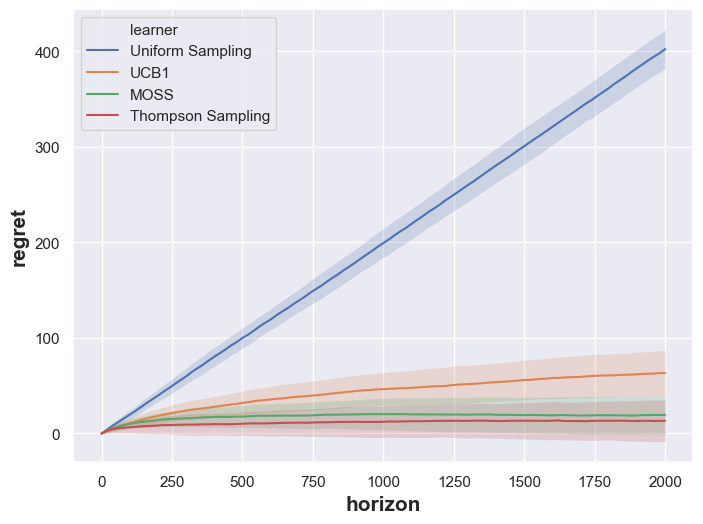

In [4]:
figure(figsize=(8, 6), dpi=100)
# add `save_fig=FILEPATH` in the arguments if you want to save the figure
df = banditpylib.plot(data, goal=config['learners']['goal'])

In [5]:
print(tabulate(df.head(), headers=["policy", "regret"]))

policy          regret
------------  --------
('MOSS', 0)      0
('MOSS', 20)     3.01
('MOSS', 40)     5.115
('MOSS', 60)     7.155
('MOSS', 80)     8.625


## Add a new policy

In [6]:
from banditpylib.learners.regretmin.ordinarylearner import OrdinaryLearner

In [7]:
import numpy as np

class ExploreThenCommit(OrdinaryLearner):
  def __init__(self, T_zero):
    self._name = 'Explore-Then-Commit'
    self.__T_zero = T_zero
    self.__commit = None

  def _learner_init(self):
    pass

  def learner_choice(self, context):
    # context is useless
    del context
    if self._t <= self.__T_zero:
        # pull each arm in a round-robin way
        return (self._t-1) % self._arm_num
    if not self.__commit:
        self.__commit = np.argmax([em_arm.em_mean for em_arm in self._em_arms])
    return self.__commit

  def _learner_update(self, context, action, feedback):
    pass

policies = [ExploreThenCommit(100)]

In [8]:
data = banditpylib.run(config, new_policies=policies)

INFO:absl:run with goal Regret Minimization
INFO:absl:run Uniform Sampling with protocol SinglePlayerRegretMinProtocol
INFO:absl:1.69 seconds elapsed
INFO:absl:run UCB1 with protocol SinglePlayerRegretMinProtocol
INFO:absl:5.05 seconds elapsed
INFO:absl:run MOSS with protocol SinglePlayerRegretMinProtocol
INFO:absl:4.98 seconds elapsed
INFO:absl:run Thompson Sampling with protocol SinglePlayerRegretMinProtocol
INFO:absl:3.94 seconds elapsed
INFO:absl:run Explore-Then-Commit with protocol SinglePlayerRegretMinProtocol
INFO:absl:1.87 seconds elapsed


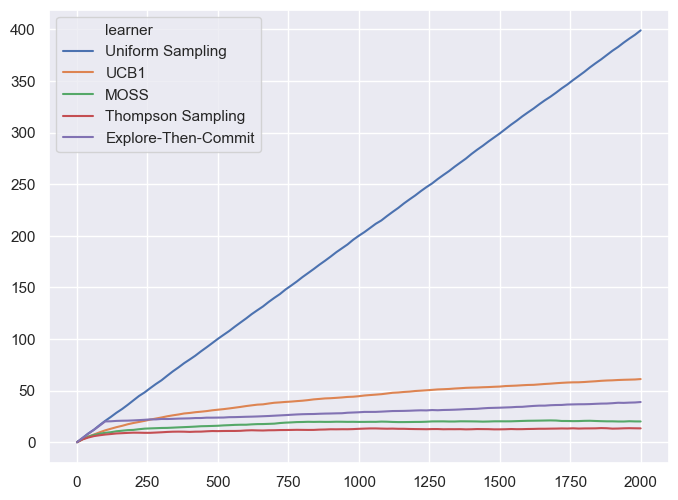

In [9]:
figure(figsize=(8, 6), dpi=100)
df = banditpylib.plot(data, goal=config['learners']['goal'], novar=True)